Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/06/01


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pydicom
import os
import pylab

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from IPython.display import display
from sklearn import metrics, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

%matplotlib inline

sb.set_style('darkgrid', {'axes.grid' : False})
my_dpi = 96

# RGB Image Feature Extraction


## Question:
Can a Restricted Boltzmann Machine(RBM) increase the accuracy of image classification, more specifically does feature extraction employing RBM increase the accuracy of predicting whether an image falls into one of 10 different catgeories of images. 

### Data:
Image data taken from university of [Toronto](http://www.cs.toronto.edu/~kriz/cifar.html). Data set consists of 7 files each containing pickeled binary arrays.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training files and one test file, each with 10000 images. The test file contains exactly 1000 randomly-selected images from each class. The training files contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Each file contains a dictionary containing two keys.  The ‘data’ key has an array of pixel data as the value.  The ‘labels’ key has a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data. These are the target values for classification.

### Context:


### Content:
Each color image is 32 x 32. The image data is pickled as separate numpy arrays in six files. The data is contain 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image. 


In [109]:
# Helpful functions for reading data files

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


Loading of pixel and label data. The test set is appended to both datasets to offer greater flexibility in constructing training testing data with train test split. 

In [110]:

root_path = '/media/ianh/space/ThinkfulData/Isitabird/cifar-10-batches-py/'
img_data = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'test_batch']
labels_file = 'batches.meta'

# Create empty numpy arrays for RBG pixel data and classification labels
pixel_list =  []
target_labels = []

for item in img_data:
    data = unpickle(root_path+item)
    pixel_list.append(data.get(b'data'))
    target_labels.extend(data.get(b'labels'))
    
pixel_data = np.concatenate(pixel_list)
target_data = np.array(target_labels)

print("\nNumber of Observations in Pixel Data : %d\n" % (pixel_data.shape[0]))
print("Number of Features in Pixel Data : %d\n" % (pixel_data.shape[1]))
print("Length of target labels array : %d\n" % (target_data.shape[0]))

# Read in labels array so that we can make sense of integer values
data = unpickle(root_path+labels_file)
ascii_labels = data.get(b'label_names')

print('Classification Labels')
print('\n% 9s' % 'integer    ascii label')
i = 0

for item in ascii_labels:
    print('% 4d - % 17s' % (i, item.decode('utf-8')))
    i += 1


Number of Observations in Pixel Data : 60000

Number of Features in Pixel Data : 3072

Length of target labels array : 60000

Classification Labels

integer    ascii label
   0 -          airplane
   1 -        automobile
   2 -              bird
   3 -               cat
   4 -              deer
   5 -               dog
   6 -              frog
   7 -             horse
   8 -              ship
   9 -             truck


### Preprocessing and exploratory data analysis

In [111]:
# Check for NaN values in data array
result = np.isnan(np.sum(pixel_data))

print('Does Pixel data have any NaN values? : %s' % ('Yes' if result else 'No') )

# Check for missing values in target array
result = np.isnan(np.sum(target_data))
print('\nDoes label data have any NaN values? : %s' % ('Yes' if result else 'No') )

Does Pixel data have any NaN values? : No

Does label data have any NaN values? : No


In [112]:
# Timing context manager for statement invocations.
# Taken from Python Cookbook section 14.13
import time

from contextlib import contextmanager
@contextmanager
def timeblock(label):
    start = time.perf_counter()
    try:
        yield
    finally:
        end = time.perf_counter()
        print('{} : {:.2f} secs'.format(label, end - start))


## Feature Extraction and Model Building


### Using the Restricted Boltzmann Machine

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Time Spent training pipeline : 2281.51 secs


[0 1 2 3 4 5 6 7 8 9]
             precision    recall  f1-score   support

   airplane       0.16      0.76      0.26      2347
 automobile       0.00      0.00      0.00      2424
       bird       0.33      0.00      0.00      2355
        cat       0.00      0.00      0.00      2407
       deer       0.00      0.00      0.00      2429
        dog       0.00      0.00      0.00      2405
       frog       0.14      0.73      0.23      2403
      horse       0.00      0.00      0.00      2415
       ship       0.00      0.00      0.00      2374
      truck       0.00      0.00      0.00      2441

avg / total       0.06      0.15      0.05     24000





/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


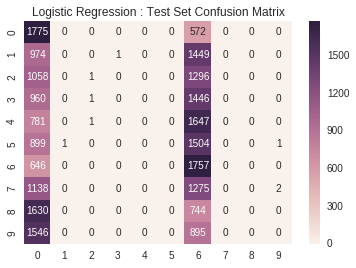

In [119]:
from sklearn.metrics import classification_report
y = target_data
X = pixel_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state=0)
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 300
logistic.C = 6000.0

# Lets not forget to Standardize the features
pipe_classifier = Pipeline(steps=[('scl', StandardScaler()), ('rbm', rbm), ('logistic', logistic)])


# Training RBM-Logistic Pipeline
with timeblock('Time Spent training pipeline'):
    pipe_classifier.fit(X_train, y_train)
    
y_ = pipe_classifier.predict(X_test)

print('\n')
print(logistic.classes_)
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(classification_report(y_test, y_, target_names=target_names))
print('\n')
cnfsn_mtrx = metrics.confusion_matrix(y_test, y_)

# Display heatmap of confusion matrix
_ = sb.heatmap(cnfsn_mtrx, annot=True, fmt="d")
_ = plt.title("Logistic Regression : Test Set Confusion Matrix")

Plot the components as constructed by the Restricted Boltzmann Machine to gain an understanding how the model is contributing to the accuracy or lack of accuracy to the classification. 

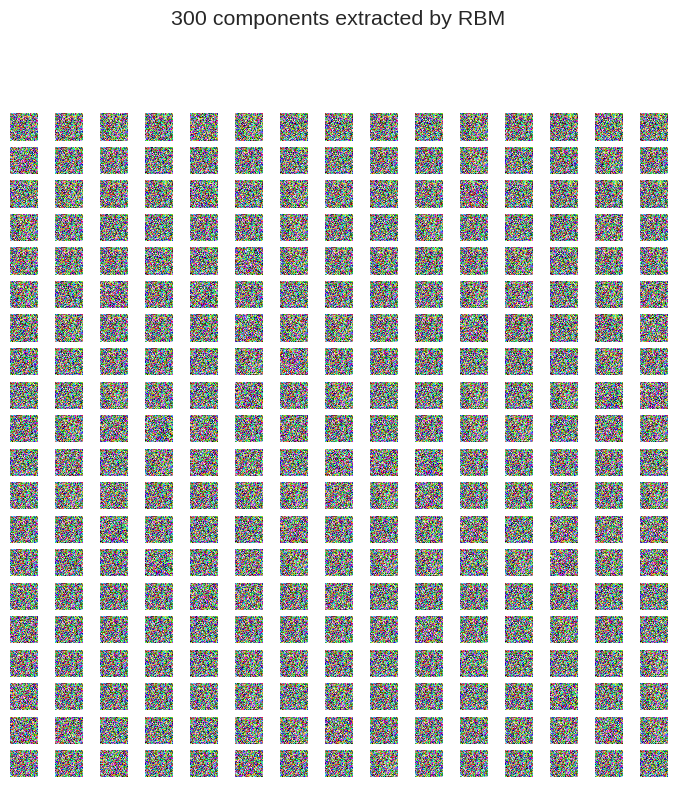

In [121]:
__ = plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
for i, comp in enumerate(rbm.components_):
    plt.subplot(20, 15, i + 1)
    img = np.reshape(comp,(32, 32, 3))
    plt.imshow(img, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('300 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)


## Discussion

Unfortunately, the model was only good at deciphering images of airplanes and frogs.  Not sure what would cause the model to fail so badly.  Several different values for number of iterations and components where tried on the RBM, but had no impact on the outcome.  Iteration values of 10, 20 and 30 were used.  Values between 200 and 500 were used for finding he optimal number of components to use.  It is unclear whether the type of image data was a problem for the Restricted Boltzmann machine.  The images are RGB and not grayscale images. 